# :: Tunable First-Order Inexact Oracles (TFOIO) ::
`Performance analysis of deterministic gradient based methods using (global) tunable first-order inexact oracles.`

**Author** : *Guillaume Van Dessel*, Ph.D. candidate @EPL

**Version** : 2.0 | working version for $d_p$=1

**Comment** : For now on, let's stick to fully deterministic methods (however those might be inexact as well but there must be 
no source of randomness at each update step apart from oracle's content)

In [1]:
## packages' import
%matplotlib notebook
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
from scipy.stats import wald,norm,f,expon,chi2,uniform
import scipy.linalg as scla
from IPython.display import display,clear_output
from ipywidgets import *
import decimal
np.warnings.filterwarnings('ignore')

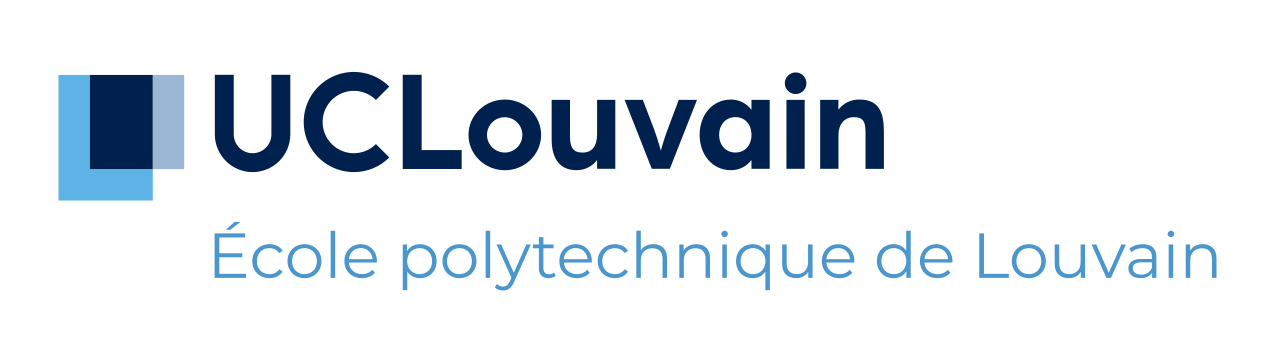

In [2]:
from IPython.display import Image
Image(filename='epl.png')

____________________________________________________________________________________

## Creation of a problem
-------------------------------

In [3]:
# @instantiation of the possibility lists 

# objective function list
obj_list = ['generic','other'] # add practical things

# search space dimension 
d = 10

#####################################################################################################################################

# @creation of inherent widgets

widget_obj = widgets.Dropdown(
    options=obj_list,
    value=obj_list[0],
    description='obj. fun.: ',
)

widget_d = widgets.IntSlider(
    value=d,
    min=1,
    max=100,
    step=1,
    description='dimension:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

widget_cons = widgets.Checkbox(
    value=False,
    description='constrained?',
    disabled=False
)

widget_distance = BoundedFloatText(
    value=1,
    min=0,
    max=1000.0,
    step=0.05,
    description='center norm:',
    disabled=False)

In [4]:
# @default Problem class
class Problem:
    
    f = lambda x: (1/2)*np.sum(x**2)
    dif_f = lambda x: x
    mu = 1
    L = 1
    d = 10
    m = 0
    constr = False
    x_star = np.zeros(d)
    scale = 5
    center = None
    type_dom = None
    update = lambda h,u: u
    
def short_not(float_number):
    return '%.3e' % decimal.Decimal(str(float_number))
    
def present_Problem():
    
    print(' ')
    print('|| problem summary ||')
    print('---------------------')
    print(' ')
    if Problem.constr:
        if Problem.type_dom is 'box':
            print('=> constrained in a box defined by :')
            if Problem.d <= 5:
                buf='['+short_not(Problem.center[0]-Problem.scale)+' , '+short_not(Problem.center[0]+Problem.scale)+']'
                for elem in np.linspace(1,Problem.d-1,Problem.d-1):
                    buf+=' X ['+short_not(Problem.center[int(elem)]-Problem.scale)+' , '\
                    +short_not(Problem.center[int(elem)]+Problem.scale)+']'
            else:
                buf = 'U from i = 1 to '+str(Problem.d)+' [c_i - '+str(Problem.scale)+' , c_i + '+str(Problem.scale)+']'
            print(buf)
        else:
            print('=> constrainted in a ball defined by : ')
            print(' B := {x in R^'+str(int(Problem.d))+' | ||x-c|| <= '+str(Problem.scale)+'}')
    else: 
        print('=> unconstrained ')
    print(' ')
    print('dimension : '+str(int(Problem.d)))
    print('estimated strong convexity parameter : '+str(Problem.mu))
    print('estimated smoothness parameter : '+str(Problem.L))
    print('activated constraints at optimum : '+str(int(Problem.m)))
    if Problem.d <= 20:
        print('optimum : '+str(Problem.x_star))
    print(' ')
    
def reset_Problem():
    
    Problem.f = lambda x: (1/2)*np.sum((x-Problem.x_star)**2)
    Problem.f = lambda x: (x-Problem.x_star)
    Problem.mu = 1
    Problem.L = 1
    Problem.d = 10

In [5]:
### models x_*
def free(dist):
    
    direc = norm.rvs(loc=0, scale=1, size=Problem.d)
    Problem.x_star = dist*direc/scla.norm(direc)
    
    Problem.center = Problem.x_star
    
    print(' ')
    print('=> a new optimizer has been chosen')
    if Problem.d <= 20:
        print(Problem.x_star)
    print(' ')
    
def ball_proj(u,center,scale):
    return center + (u-center)/np.max([scale,scla.norm(u-center)])
    
def ball_constraint(center,m,scale):
    
    Problem.m = m
    Problem.scale = scale
    Problem.update = lambda h,u: ball_proj(u,Problem.center,Problem.scale)
    
    direc = norm.rvs(loc=0, scale=1, size=Problem.d)
    
    if m==1:
        Problem.x_star = center+scale*direc/scla.norm(direc)
    else:
        Problem.x_star = center+(scale*np.random.uniform(0,1)**(1/Problem.d))*direc/scla.norm(direc)
        
    print(' ')
    print('=> a new optimizer has been chosen')
    if Problem.d <= 20:
        print(Problem.x_star)
    print(' ')
    
def box_proj(u,center,scale):
    buf = []
    bounds = [center-scale,center+scale]
    for j in np.arange(len(u)):
        if u[j]<bounds[0][j]:
            buf.append(bounds[0][j])
        elif u[j]>bounds[1][j]:
            buf.append(bounds[1][j])
        else:
            buf.append(u[j])
    return np.array(buf)
        
def box_constraint(center,m,scale):
    
    Problem.m = m
    Problem.scale = scale
    Problem.update = lambda h,u: box_proj(u,Problem.center,Problem.scale)
    
    bounds = [center-Problem.scale,center+Problem.scale]
    
    if m>0:
        indices = np.random.choice(np.arange(Problem.d),m,False)
        buf = np.zeros(Problem.d)
        for elem in np.arange(Problem.d):
            if elem in indices:
                buf[elem] = np.random.choice([bounds[0][elem],bounds[1][elem]],1)[0]
            else:
                buf[elem] = np.random.uniform(bounds[0][elem],bounds[1][elem],1)
        Problem.x_star = buf
    else:
        Problem.x_star = np.random.uniform(bounds[0],bounds[1],Problem.d)
        
    print(' ')
    print('=> a new optimizer has been chosen')
    if Problem.d <= 20:
        print(Problem.x_star)
    print(' ')
    
def constraint(dist,cstr_type='box'):
    
    direc = norm.rvs(loc=0, scale=1, size=Problem.d)
    cent = dist*direc/scla.norm(direc)
    
    Problem.center = cent
    
    widget_scale = BoundedFloatText(
    value=1,
    min=0,
    max=1000.0,
    step=0.05,
    description='scale:',
    disabled=False)
    
    if cstr_type is 'ball':
        
        Problem.type_dom = 'ball'
    
        widget_m = widgets.IntSlider(
        value=0,
        min=0,
        max=1,
        step=1,
        description='number of activated constraints at x_*:')
        
        interact(lambda m,scale: ball_constraint(cent,m,scale),m=widget_m,scale=widget_scale)
    
    else:
        
        Problem.type_dom = 'box'
        
        widget_m = widgets.IntSlider(
        value=0,
        min=0,
        max=Problem.d,
        step=1,
        description='number of activated constraints at x_*:')
        
        interact(lambda m,scale: box_constraint(cent,m,scale),m=widget_m,scale=widget_scale)

In [6]:
### models for f and del f

# generic
def generic(alpha=0.1,beta=1.25,gamma=9.8):
    
    # @priori s.c. and smoothness parameters
    Problem.mu = alpha
    Problem.L = alpha + 4*beta + gamma/2 
    
    def z(x):
        return (1/2)*np.sum(x**2)
    
    def grad_z(x):
        return x
    
    def g(x):
        return (1/2)*(x[0]**2 + x[-1]**2 + np.sum((x[:-1]-x[1:])**2))
    
    def grad_g(x):
        zer = np.zeros(1)
        _x = np.concatenate((zer,x[:-1]),axis=None)
        x_ = np.concatenate((x[1:],zer),axis=None)
        return 2*x - (_x + x_)
    
    def h(x):
        delta = np.max(x)
        return delta + np.log(np.sum(np.exp(x-delta)))
    
    def grad_h(x):
        delta = np.max(x)
        u = np.exp(x-delta)
        return u/np.sum(u)
    
    x_star = Problem.x_star
    h_star = h(x_star)
    grad_h_star = grad_h(x_star)
    
    # first order information
    
    Problem.f = lambda x: alpha*z(x-x_star) + beta*g(x-x_star) +\
            gamma*(h(x)-h_star-(grad_h_star@(x-x_star)))
    
    Problem.dif_f = lambda x: alpha*grad_z(x-x_star) + beta*grad_g(x-x_star)+\
            gamma*(grad_h(x)-grad_h_star)

In [7]:
### aux. methods

def change_optimizer(dimension,boolean,distance=5):
    
    Problem.d = int(dimension)
    Problem.constr = boolean
    
    if boolean: # only box, ball
        
        widget_type = widgets.Dropdown(
        options=['box','ball'],
        value='box',
        description='constraint type: ')
        
        interact(lambda cstr_type: constraint(distance,cstr_type), cstr_type = widget_type)
        
    else:
        
        free(distance)
        

def change_obj(string):
    
    if string is 'generic':
        
        yf = widgets.HTMLMath(value=r'$$f(x) = \frac{\alpha}{2}\,||x-x_*||^2 + \beta \, g(x-x_*) + \gamma \, [h(x) - h(x_*) \
        - \langle \nabla h(x_*) \, , \, x-x_* \rangle] $$')
        ye = widgets.Label(value='where')
        yg = widgets.HTMLMath(value=r'$$g(x) = \frac{1}{2}\,[x_{1}^2 + \sum_{i=1}^{d}\, (x_{i} - x_{i+1})^2 + x_{d}^2]$$')
        yh = widgets.HTMLMath(value=r'$$h(x) = \log(\sum_{i=1}^{d} \, e^{x_{i}})$$')
        display(yf,ye,yg,yh)
        
        widget_alpha = BoundedFloatText(
            value=0.1,
            min=0,
            max=100.0,
            step=0.01,
            description='alpha:',
            disabled=False)
        
        widget_beta = BoundedFloatText(
            value=1.25,
            min=0,
            max=100000.0,
            step=0.05,
            description='beta:',
            disabled=False)
        
        widget_gamma = BoundedFloatText(
            value=9.8,
            min=0,
            max=500000.0,
            step=0.2,
            description='gamma:',
            disabled=False)
        
        # exact f,dif functions 
        interact(generic,alpha = widget_alpha,beta = widget_beta, gamma = widget_gamma);
        
    else:
        
        # default f,dif functions 
        reset_Problem()
        y = widgets.HTMLMath(value=r'$$f(x) = \frac{||x-x_*||^2}{2}$$')
        display(y)

In [8]:
# optimum 
interact(change_optimizer,dimension = widget_d,boolean = widget_cons, distance = widget_distance);

interactive(children=(IntSlider(value=10, continuous_update=False, description='dimension:', min=1), Checkbox(…

In [9]:
# objective function
interact(change_obj,string = widget_obj);

interactive(children=(Dropdown(description='obj. fun.: ', options=('generic', 'other'), value='generic'), Outp…

In [10]:
button = widgets.Button(description="Load Problem")
output = widgets.Output()

display(button, output)

def on_button_clicked(b):
    with output:
        clear_output()
        present_Problem()

button.on_click(on_button_clicked)

Button(description='Load Problem', style=ButtonStyle())

Output()

## Easy-to-go results 
------------------------------

Using *Devolder* type first-order tunable inexact oracles with fixed $\mu \leq L$, i.e. $\mathcal{T}_k = (\delta(\eta_k),L,\mu)$, $\forall k \in \{0,\dots,N-1\}$, one can show that 

$$ f(\hat{x}_N) - f^* \leq \frac{LR^2 \gamma_N}{2 W_N} + \frac{\sum_{k=0}^{N-1} w_k\, \delta(\eta_k)}{W_N}$$

where the coefficients $\gamma_N$, $\{w_k\}_{k=0}^{N-1}$ and $W_N$ are defined for every $N \in \mathbb{N}$ as in the following table.

<table>
    <tr>
        <td>
\begin{eqnarray}
          & & \gamma_N & w_k & W_{N} \\
     -----& -----|& ------& ------& -----\\
\text{GD} & & \rho^N & \rho^{N-1-k} & \sum_{k=0}^{N-1} \rho^{N-1-k} \\
\text{FGD} & & 1 & A_k & A_{N-1} \\
\end{eqnarray}
        </td>
    </tr>
</table>

where $A_k = \sum_{i=0}^k \alpha_k$ for which a reccurence is set up : $\alpha_0 \in ]0,1], \hspace{2pt} L+\mu\,A_k \geq \frac{L\alpha_{k+1}^2}{A_{k+1}}$ and $\rho = (1-\frac{\mu}{L})$.

## Choice of a model
-----------------------------

#### basic delta model
------------------------------------------------------


 $$ \delta(\eta_k) = q\frac{\eta_k^j}{j}$$
 
 Do not forget that $\ell_a \succeq \mathbf{0}$ in order to ensure convexity.

In [11]:
j = 2
mult_i = 3
mult_ii = (2*Problem.L + Problem.mu)/(Problem.L*Problem.mu) # Problem.mu should be strictly positive

def delta_i(eta):
    return mult_i*eta**j / j

def delta_ii(eta):
    return mult_ii*e**j / j

#### basic cost models
------------------------------------------------------

for all $k \in \{0,...,N-1\}$,

 (i)$$ \mathcal{M}_k(\eta_k) = K + \frac{\beta}{(\eta_k)^r}$$
 (ii) $$ \mathcal{M}_k(\eta_k) = K - \beta \log(\eta_k) $$

<IPython.core.display.Javascript object>


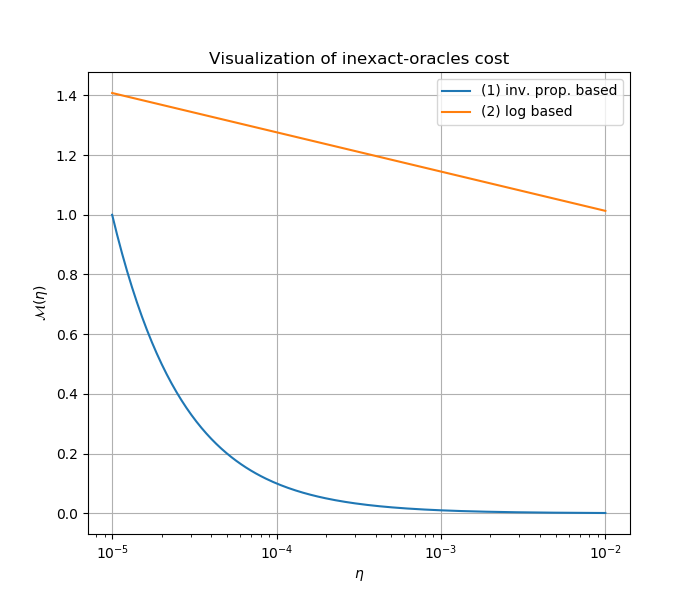

In [12]:
# c1 < c3*c2 to avoid convexity issues in (c1*delta + c2)/(1+c3*delta)
scaler_i = 1e-8
scaler_ii = 0.75
r = 1
K = 1
la = 2e-6
lb = 1e-2
la_exp = int(np.log10(la))
lb_exp = int(np.log10(lb))
beta_i = 1e3
beta_ii = 1/np.log(1/la)


def base_cost_i(eta):
    return scaler_i*(K+beta_i/(eta)**r)

def total_cost_i(etas):
    return scaler_i*(len(etas)*K + beta_i*np.sum(1/(+etas)**r))

def diff_total_cost_i(etas):
    return scaler_i*(-r*beta_i/(etas)**(r+1))

def base_cost_ii(eta):
    return scaler_ii*(K-beta_ii*np.log(eta))

def total_cost_i(etas):
    return scaler_ii*(len(etas)*K - beta_ii*np.sum(np.log(etas)))

def diff_total_cost_i(etas):
    return scaler_ii*(-beta_ii/(etas))


etas = np.logspace(la_exp,lb_exp,200)
plt.figure(figsize=(7,6))
plt.title('Visualization of inexact-oracle''s cost')
plt.xlabel('$\eta$')
plt.ylabel('$\mathcal{M}(\eta)$')
plt.grid()
plt.semilogx(etas,base_cost_i(etas))
plt.semilogx(etas,base_cost_ii(etas))
plt.legend(['(1) inv. prop. based','(2) log based']);
plt.savefig('costs.pdf')

In [13]:
#  gamma_N / w_k / W_N (+ alpha_k in full mode turned on True and in 'FGD')

def compute_serial_coeffs(N=100,L=4,mu=0.01,mode = 'GD', full=False):
    if mode=='FGD':
        a_0 = 1 # shouldn't be changed
        a_list = [a_0]
        A = a_0
        A_list = [a_0]
        for k in np.arange(1,N):
            base = (L+mu*A)/L 
            buf = (base+np.sqrt(base**2 + 4*base*A))/2
            a_list.append(buf)
            A += buf
            A_list.append(A)
        ret = np.array(A_list)
        if full:
            return 1,ret,ret[-1],np.array(a_list)
        else:
            return 1,ret,ret[-1]
    else:
        N_list = np.arange(N)
        rho = (1-mu/L)
        ret = rho**(N-1-N_list)
        return rho**N,ret,np.sum(ret)

In [14]:
# non-opt as recomputation of coefficients gamma_N,w_k's, ... etc
def N_lower(L=10,mu=0.1,mode='FGD',epsilon=1e-5,R=10,j=1,q=1,la=5e-7,verbose=False):
    
    # params
    delta_fun = lambda eta: (q/j)*eta**(j)
    N_max_default = int(1e4)
    mult = 2
    N_min = int(1)
    N_current = N_min
    non_feas = True
    
    # find better suitable N_max
    while (non_feas and N_current < N_max_default):
        N_current = np.floor(N_current*mult)
        gamma_N,w_k,W_N = compute_serial_coeffs(int(N_current),L,mu,mode)
        Gamma_N_eps = W_N*epsilon - (gamma_N*L*R**2)/2
        non_feas = (Gamma_N_eps - np.sum(w_k)*delta_fun(la))<0
        
    N_max = np.min([N_current,N_max_default])
    if verbose:
        print('bounds found at for N_min: ['+str(int(N_min))+', '+str(int(N_max))+']')
    
    # bisection 
    while N_max-N_min>1:
        N_current = np.floor((N_max+N_min)/2)
        gamma_N,w_k,W_N = compute_serial_coeffs(int(N_current),L,mu,mode)
        Gamma_N_eps = W_N*epsilon - (gamma_N*L*R**2)/2
        feas = (Gamma_N_eps - np.sum(w_k)*delta_fun(la))>=0
        if feas:
            N_max = N_current
        else:
            N_min = N_current
            
    if verbose:
        print('final estimation for N_min: '+str(int(N_max)))
    return int(N_max)

In [15]:
# @default Instance class
class Instance:
    
    cost_model = 'minus_log'
    met = 'FGD'
    q = 1
    K = 1e3
    beta = 1
    r = 1
    j = 1
    epsilon = 5e-5
    N = 150
    la = 5e-7
    lb = 1e-3
    R = 10

In [16]:
def partitioner(N,conv_term=1e-5,error_term=2e-5):

    repartition = [conv_term,error_term]
    repartition.append(np.sum(repartition))
    sources = np.arange(len(repartition))
    
    print('percentages : conv term <- '+str(conv_term/(conv_term+error_term))+' , error term <- '+str(error_term/(conv_term+error_term)))

    fig, ax = plt.subplots(figsize=(9,6))
    plt.grid(axis='y')
    barlist = plt.bar(sources,repartition)
    plt.title('Repartition of the accuracy for N = '+str(int(N)))
    plt.xticks(sources, ('Convergence Term', 'Error Term','Target Accuracy'))
    barlist[0].set_color('orange')
    barlist[1].set_color('red')
    barlist[2].set_color('blue')
    plt.show()

In [17]:
def change2_obj(cm,met,q,K,beta2,r,j,epsilon,N,la,lb,R):
    
    delta_fun = lambda eta: (q/j)*eta**(j)
    gamma_N,w_k,W_N = compute_serial_coeffs(N,Problem.L,Problem.mu,met)
    Gamma_N_eps = W_N*epsilon - (gamma_N*Problem.L*R**2)/2
    rest = np.sum(w_k)*delta_fun(la)
    if Gamma_N_eps>rest:
        print(' preview ok => Gamma_N_eps = '+str(Gamma_N_eps)+' , (sum_k w_k) delta(la) = '+str(rest))
    else:
        print(' preview not ok => Gamma_N_eps = '+str(Gamma_N_eps)+' , (sum_k w_k) delta(la) = '+str(rest))
        
    gamma_N_begin,_,W_N_begin = compute_serial_coeffs(N,Problem.L,Problem.mu,met)
    conv_term_begin = (gamma_N_begin*Problem.L*R**2)/(2*W_N_begin)
    error_term_begin = epsilon-conv_term_begin
    partitioner(N,conv_term_begin,error_term_begin)

    Instance.cost_model = cm
    Instance.met = met
    Instance.q = q
    Instance.K = K
    Instance.beta = beta2
    Instance.r = r
    Instance.j = j
    Instance.epsilon = epsilon
    Instance.N = N
    Instance.la = la
    Instance.lb = lb
    Instance.R = R

In [18]:
# @instantiation of the possibility lists 

# cost model list
cost_model_list = ['minus_log','inv_prop'] # add practical things

# method list
met_list = ['FGD','GD']

# inaccuracy level distribution list
dst_list = ['uniform','exponential','F','chi2','wald']

#####################################################################################################################################

# @creation of inherent widgets

widget_cost_model = widgets.Dropdown(
    options=cost_model_list,
    value=cost_model_list[0],
    description='cost model: ',
)

widget_met = widgets.Dropdown(
    options=met_list,
    value=met_list[0],
    description='method: ',
)

widget_dst = widgets.Dropdown(
    options=dst_list,
    value=dst_list[0],
    description='distrib. level: ',
)

widget_epsilon = BoundedFloatText(
    value=1e-5,
    min=1e-10,
    max=1,
    step=1e-6,
    description='epsilon:',
    disabled=False)

widget_N =widgets.BoundedIntText(
    value=151,
    min=1,
    max=10000,
    step=5,
    description='N:',
    disabled=False
)

widget_K = BoundedFloatText(
    value=1000,
    min=0,
    max=10000.0,
    step=1,
    description='K:',
    disabled=False)

widget_R = BoundedFloatText(
    value=10,
    min=0,
    max=1000,
    step=1,
    description='R:',
    disabled=False)

widget_q = BoundedFloatText(
    value=1,
    min=0,
    max=10,
    step=0.01,
    description='q:',
    disabled=False)

widget_beta2 = BoundedFloatText(
    value=1,
    min=0,
    max=10,
    step=0.001,
    description='beta:',
    disabled=False)

widget_r = BoundedFloatText(
    value=1.0,
    min=0,
    max=100.0,
    step=0.5,
    description='r:',
    disabled=False)

widget_j = BoundedFloatText(
    value=1.0,
    min=0,
    max=100.0,
    step=0.5,
    description='j:',
    disabled=False)

widget_la = BoundedFloatText(
    value=5e-7,
    min=0,
    max=100,
    step=1e-8,
    description='la:',
    disabled=False)

widget_lb = BoundedFloatText(
    value=100000,
    min=0,
    max=100000,
    step=1e-8,
    description='lb:',
    disabled=False)

In [19]:
def set_to_N_min():
    N_min  = N_lower(Problem.L,Problem.mu,Instance.met,Instance.epsilon,Instance.R,Instance.j,Instance.q,Instance.la,False)
    Instance.N = N_min
    widget_N.value = N_min

In [20]:
def experiment_i_imp(N=151,L=10,mu=0.1,mode='FGD',epsilon=1e-5,R=10,j=1,q=1,r=1,la=5e-7,lb=1e-3,beta=1,display=True):
    N_list = np.arange(N+1)
    delta_fun = lambda eta: (q/j)*eta**(j)
    gamma_N,w_k,W_N = compute_serial_coeffs(N,L,mu,mode)
    Gamma_N_eps = W_N*epsilon - (gamma_N*L*R**2)/2
    check_feas = (Gamma_N_eps - np.sum(w_k)*delta_fun(la) >= 0) # check feasibility
    if check_feas==False:
        if display:
            print(' => error infeasible || '+'Gamma_N_eps = '+str(Gamma_N_eps)+' , (sum_k w_k) delta(la) = '+str(np.sum(w_k)*delta_fun(la)))
    else: # lin-search
        if display:
            print(' => experiment started || '+'Gamma_N_eps = '+str(Gamma_N_eps)+' , (sum_k w_k) delta(la) = '+str(np.sum(w_k)*delta_fun(la)))
        Na_list = np.arange(N+1)
        Nb_list = np.arange(N+1)
        NA,NB = np.meshgrid(Na_list,Nb_list)
        lambda_0_opt_hat_mesh = []
        lambda_0_max = 0
        Na_best,Nb_best = 0,0
        Na_best0 = 0
        lambda_0_max0 = 0
        ok_counter = 0
        ok_NaNb = []
        
        # clear version (not optimized though)
        
        for ind_Nb_list in np.arange(len(Nb_list)):
            Nb_tilde_hat = Nb_list[ind_Nb_list]
            lambda_0_opt_hat_Nb_fixed = []
            for ind_Na_list in np.arange(len(Na_list)):
                Na_tilde_hat = Na_list[ind_Na_list]
                # not a possible case
                if Nb_tilde_hat+Na_tilde_hat>N:
                    lambda_0_opt_hat_Nb_fixed.append(np.nan) # neutral for plots here
                else:
                    Psi_N_eps = Gamma_N_eps - delta_fun(la)*np.sum(w_k[N-Na_tilde_hat:N]) - delta_fun(lb)*np.sum(w_k[:Nb_tilde_hat])
                    Upsilon_N = np.sum((q*w_k[Nb_tilde_hat:N-Na_tilde_hat])**(r/(r+j))) * ((r*beta)**(j/(r+j)))/j
                    lambda_0_opt_hat = (Upsilon_N/Psi_N_eps)**((r+j)/j)
                       
                    if Psi_N_eps<0:
                        lambda_0_opt_hat = np.nan
                    else:
                        if Na_tilde_hat>0:
                            feas1 = (lambda_0_opt_hat - (r*beta)/(q*la**(r+j)*w_k[int(N-Na_tilde_hat)]))>=0
                        else:
                            feas1 = True
                        if Nb_tilde_hat>0:
                            feas2 = (lambda_0_opt_hat - (r*beta)/(q*lb**(r+j)*w_k[int(Nb_tilde_hat-1)]))<=0
                        else:
                            feas2 = True
                        if Na_tilde_hat<N:
                            feas3 = (lambda_0_opt_hat - (r*beta)/(q*la**(r+j)*w_k[int(N-Na_tilde_hat-1)]))<0
                        else:
                            feas3 = True
                        if Nb_tilde_hat<N:
                            feas4 = (lambda_0_opt_hat - (r*beta)/(q*lb**(r+j)*w_k[int(Nb_tilde_hat)]))>0
                        else:
                            feas4 = True

                        feas = feas1 and feas2 and feas3 and feas4

                        if feas:
                            ok_counter+=1
                            ok_NaNb.append((Na_tilde_hat,Nb_tilde_hat))
                            if lambda_0_opt_hat > lambda_0_max:
                                Na_best,Nb_best = Na_tilde_hat,Nb_tilde_hat
                                lambda_0_max = lambda_0_opt_hat
                            
                    lambda_0_opt_hat_Nb_fixed.append(np.log10(lambda_0_opt_hat))
                    
            if Nb_tilde_hat==0:
                Na_best0 = np.nanargmax(np.array(lambda_0_opt_hat_Nb_fixed))
                lambda_0_max0 = lambda_0_opt_hat_Nb_fixed[Na_best0]
            lambda_0_opt_hat_mesh.append(lambda_0_opt_hat_Nb_fixed)
        
        if display:
            print('/!\ KKT fulfilled at max hat_lambda_0^* for (Na,Nb) = ('+str(Na_best)+', '+str(Nb_best)+') /!\ ')
            print('total number of OK points in (Na,Nb) space: '+str(ok_counter))
        
    return Na_best,Nb_best,lambda_0_max,Na_best0,lambda_0_max0,NA,NB,lambda_0_opt_hat_mesh,Na_list

In [21]:
def experiment_ii_imp(N=151,L=10,mu=0.1,mode='FGD',epsilon=1e-5,R=10,j=1,q=1,la=5e-7,lb=1e-3,beta=1,display=True):
    N_list = np.arange(N+1)
    delta_fun = lambda eta: (q/j)*eta**(j)
    gamma_N,w_k,W_N = compute_serial_coeffs(N,L,mu,mode)
    Gamma_N_eps = W_N*epsilon - (gamma_N*L*R**2)/2
    check_feas = (Gamma_N_eps - np.sum(w_k)*delta_fun(la) >= 0) # check feasibility
    if check_feas==False:
        if display:
            print(' => error infeasible || '+'Gamma_N_eps = '+str(Gamma_N_eps)+' , (sum_k w_k) delta(la) = '+str(np.sum(w_k)*delta_fun(la)))
    else: # lin-search
        if display:
            print(' => experiment started || '+'Gamma_N_eps = '+str(Gamma_N_eps)+' , (sum_k w_k) delta(la) = '+str(np.sum(w_k)*delta_fun(la)))
        Na_list = np.arange(N+1)
        Nb_list = np.arange(N+1)
        NA,NB = np.meshgrid(Na_list,Nb_list)
        lambda_0_opt_hat_mesh = []
        lambda_0_max = 0
        Na_best,Nb_best = 0,0
        Na_best0 = 0
        lambda_0_max0 = 0
        ok_counter = 0
        ok_NaNb = []
        
        # clear version (not optimized though)
        
        for ind_Nb_list in np.arange(len(Nb_list)):
            Nb_tilde_hat = Nb_list[ind_Nb_list]
            lambda_0_opt_hat_Nb_fixed = []
            for ind_Na_list in np.arange(len(Na_list)):
                Na_tilde_hat = Na_list[ind_Na_list]
                # not a possible case
                if Nb_tilde_hat+Na_tilde_hat>N:
                    lambda_0_opt_hat_Nb_fixed.append(np.nan) # neutral for plots here
                else:
                    Psi_N_eps = Gamma_N_eps - delta_fun(la)*np.sum(w_k[N-Na_tilde_hat:N]) - delta_fun(lb)*np.sum(w_k[:Nb_tilde_hat])
                    Upsilon_N = np.sum((q*w_k[Nb_tilde_hat:N-Na_tilde_hat])**(0) * ((beta)**(1))/j)
                    lambda_0_opt_hat = (Upsilon_N/Psi_N_eps)**(1)
                    if Psi_N_eps<0:
                        lambda_0_opt_hat = np.nan
                    else:
                        if Na_tilde_hat>0:
                            feas1 = (lambda_0_opt_hat - (beta)/(q*la**(j)*w_k[int(N-Na_tilde_hat)]))>=0
                        else:
                            feas1 = True
                        if Nb_tilde_hat>0:
                            feas2 = (lambda_0_opt_hat - (beta)/(q*lb**(j)*w_k[int(Nb_tilde_hat-1)]))<=0
                        else:
                            feas2 = True
                        if Na_tilde_hat<N:
                            feas3 = (lambda_0_opt_hat - (beta)/(q*la**(j)*w_k[int(N-Na_tilde_hat-1)]))<0
                        else:
                            feas3 = True
                        if Nb_tilde_hat<N:
                            feas4 = (lambda_0_opt_hat - (beta)/(q*lb**(j)*w_k[int(Nb_tilde_hat)]))>0
                        else:
                            feas4 = True

                        feas = feas1 and feas2 and feas3 and feas4

                        if feas:
                            ok_counter+=1
                            ok_NaNb.append((Na_tilde_hat,Nb_tilde_hat))
                            if lambda_0_opt_hat > lambda_0_max:
                                Na_best,Nb_best = Na_tilde_hat,Nb_tilde_hat
                                lambda_0_max = lambda_0_opt_hat

                    lambda_0_opt_hat_Nb_fixed.append(np.log10(lambda_0_opt_hat))
            if Nb_tilde_hat==0:
                Na_best0 = np.nanargmax(np.array(lambda_0_opt_hat_Nb_fixed))
                lambda_0_max0 = lambda_0_opt_hat_Nb_fixed[Na_best0]
            lambda_0_opt_hat_mesh.append(lambda_0_opt_hat_Nb_fixed)
            
        
        if display:
            print('/!\ KKT fulfilled at max hat_lambda_0^* for (Na,Nb) = ('+str(Na_best)+', '+str(Nb_best)+') /!\ ')
            print('total number of OK points in (Na,Nb) space: '+str(ok_counter))
           
    return Na_best,Nb_best,lambda_0_max,Na_best0,lambda_0_max0,NA,NB,lambda_0_opt_hat_mesh,Na_list

In [22]:
def kkt_i_imp(N=151,L=10,mu=0.1,mode='FGD',epsilon=1e-5,R=10,j=1,q=1,r=1,la=5e-7,lb=1e-3,beta=1,display=True):
   
    N_list = np.arange(N+1)
    delta_fun = lambda eta: (q/j)*eta**(j)
    gamma_N,w_k,W_N = compute_serial_coeffs(N,L,mu,mode)
    Gamma_N_eps = W_N*epsilon - (gamma_N*L*R**2)/2
    check_feas = (Gamma_N_eps - np.sum(w_k)*delta_fun(la) >= 0) # check feasibility
   
    if check_feas==False:
       
        if display:
            print(' => error infeasible || '+'Gamma_N_eps = '+str(Gamma_N_eps)+' , (sum_k w_k) delta(la) = '+str(np.sum(w_k)*delta_fun(la)))
    
    else: # lin-search
       
        if display:
            print(' => experiment started || '+'Gamma_N_eps = '+str(Gamma_N_eps)+' , (sum_k w_k) delta(la) = '+str(np.sum(w_k)*delta_fun(la)))
        
        Na_list = np.arange(N+1)
        if lb == widget_lb.max:
            Nb_list = np.array([0])
        else:
            Nb_list = np.arange(N+1)
        Nb_bound = np.max(Nb_list)
        ind_Nb_list = int(0)
        ind_Na_list = int(0)
        
        # clear version (not optimized though)
        
        while ind_Nb_list <= Nb_bound:
            Nb_tilde_hat = Nb_list[ind_Nb_list]
            ind_Na_list = int(0)
            while ind_Na_list <= N:
                Na_tilde_hat = Na_list[ind_Na_list]
                if Nb_tilde_hat+Na_tilde_hat<=N:
                    Psi_N_eps = Gamma_N_eps - delta_fun(la)*np.sum(w_k[N-Na_tilde_hat:N]) - delta_fun(lb)*np.sum(w_k[:Nb_tilde_hat])
                    Upsilon_N = np.sum((q*w_k[Nb_tilde_hat:N-Na_tilde_hat])**(r/(r+j))) * ((r*beta)**(j/(r+j)))/j
                    lambda_0_opt_hat = (Upsilon_N/Psi_N_eps)**((r+j)/j)
                    if Psi_N_eps<0:
                        feas = False
                    else:
                        if Na_tilde_hat>0:
                            feas1 = (lambda_0_opt_hat - (r*beta)/(q*la**(r+j)*w_k[int(N-Na_tilde_hat)]))>=0
                        else:
                            feas1 = True
                        if Nb_tilde_hat>0:
                            feas2 = (lambda_0_opt_hat - (r*beta)/(q*lb**(r+j)*w_k[int(Nb_tilde_hat-1)]))<=0
                        else:
                            feas2 = True
                        if Na_tilde_hat<N:
                            feas3 = (lambda_0_opt_hat - (r*beta)/(q*la**(r+j)*w_k[int(N-Na_tilde_hat-1)]))<0
                        else:
                            feas3 = True
                        if Nb_tilde_hat<N and (lb!=widget_lb.max):
                            feas4 = (lambda_0_opt_hat - (r*beta)/(q*lb**(r+j)*w_k[int(Nb_tilde_hat)]))>0
                        else:
                            feas4 = True

                        feas = feas1 and feas2 and feas3 and feas4
                else:
                    feas = False
                    
                if feas:
                    Na_best = Na_tilde_hat
                    Nb_best = Nb_tilde_hat
                    lambda_0_max = lambda_0_opt_hat
                    ind_Nb_list = N+1
                    ind_Na_list = N+1
                else:
                    ind_Na_list += int(1)
            ind_Nb_list += int(1)
        
        if display:
            print('/!\ KKT fulfilled for (Na,Nb) = ('+str(Na_best)+', '+str(Nb_best)+') /!\ ')
           
        return Na_best,Nb_best,lambda_0_max,w_k,W_N

In [23]:
def kkt_i_imp_bisec(N=151,L=10,mu=0.1,mode='FGD',epsilon=1e-5,R=10,j=1,q=1,r=1,la=5e-7,lb=1e-3,beta=1,display=True):
   
    N_list = np.arange(N+1)
    delta_fun = lambda eta: (q/j)*eta**(j)
    gamma_N,w_k,W_N = compute_serial_coeffs(N,L,mu,mode)
    Gamma_N_eps = W_N*epsilon - (gamma_N*L*R**2)/2
    check_feas = (Gamma_N_eps - np.sum(w_k)*delta_fun(la) >= 0) # check feasibility
   
    if check_feas==False:
       
        if display:
            print(' => error infeasible || '+'Gamma_N_eps = '+str(Gamma_N_eps)+' , (sum_k w_k) delta(la) = '+str(np.sum(w_k)*delta_fun(la)))
    
    else: # bisection-search
       
        if display:
            print(' => experiment started || '+'Gamma_N_eps = '+str(Gamma_N_eps)+' , (sum_k w_k) delta(la) = '+str(np.sum(w_k)*delta_fun(la)))
        
        if lb == widget_lb.max:
            Nb_list = np.array([0])
        else:
            Nb_list = np.arange(N+1)
        Nb_bound = np.max(Nb_list)
        ind_Nb_list = int(0)
        
        # clear version (not optimized though)
        
        while ind_Nb_list <= Nb_bound:
            
            Nb_tilde_hat = Nb_list[ind_Nb_list]
            Na_min,Na_max = 0,N-Nb_tilde_hat
            
            while Na_max-Na_min > 0:
                
                Na_tilde_hat = int(np.floor((Na_max+Na_min)/2))
                
                Psi_N_eps = Gamma_N_eps - delta_fun(la)*np.sum(w_k[N-Na_tilde_hat:N]) - delta_fun(lb)*np.sum(w_k[:Nb_tilde_hat])
                Upsilon_N = np.sum((q*w_k[Nb_tilde_hat:N-Na_tilde_hat])**(r/(r+j))) * ((r*beta)**(j/(r+j)))/j
                lambda_0_opt_hat_prev = (Upsilon_N/Psi_N_eps)**((r+j)/j)
                
                Na_tilde_hat = int(Na_tilde_hat+1)
                
                Psi_N_eps = Gamma_N_eps - delta_fun(la)*np.sum(w_k[N-Na_tilde_hat:N]) - delta_fun(lb)*np.sum(w_k[:Nb_tilde_hat])
                Upsilon_N = np.sum((q*w_k[Nb_tilde_hat:N-Na_tilde_hat])**(r/(r+j))) * ((r*beta)**(j/(r+j)))/j
                lambda_0_opt_hat_next = (Upsilon_N/Psi_N_eps)**((r+j)/j)
                
                if lambda_0_opt_hat_next-lambda_0_opt_hat_prev>0:
                    Na_min = int(Na_tilde_hat)
                else:
                    Na_max = int(Na_tilde_hat-1)
              
            Na_tilde_hat = int(Na_min)
            Psi_N_eps = Gamma_N_eps - delta_fun(la)*np.sum(w_k[N-Na_tilde_hat:N]) - delta_fun(lb)*np.sum(w_k[:Nb_tilde_hat])
            Upsilon_N = np.sum((q*w_k[Nb_tilde_hat:N-Na_tilde_hat])**(r/(r+j))) * ((r*beta)**(j/(r+j)))/j
            lambda_0_opt_hat = (Upsilon_N/Psi_N_eps)**((r+j)/j)
            
            if Psi_N_eps<0:
                feas = False
            else:
                if Na_tilde_hat>0:
                    feas1 = (lambda_0_opt_hat - (r*beta)/(q*la**(r+j)*w_k[int(N-Na_tilde_hat)]))>=0
                else:
                    feas1 = True
                if Nb_tilde_hat>0:
                    feas2 = (lambda_0_opt_hat - (r*beta)/(q*lb**(r+j)*w_k[int(Nb_tilde_hat-1)]))<=0
                else:
                    feas2 = True
                if Na_tilde_hat<N:
                    feas3 = (lambda_0_opt_hat - (r*beta)/(q*la**(r+j)*w_k[int(N-Na_tilde_hat-1)]))<0
                else:
                    feas3 = True
                if Nb_tilde_hat<N and (lb!=widget_lb.max):
                    feas4 = (lambda_0_opt_hat - (r*beta)/(q*lb**(r+j)*w_k[int(Nb_tilde_hat)]))>0
                else:
                    feas4 = True

                feas = feas1 and feas2 and feas3 and feas4
            
            if feas:
                Na_best = Na_tilde_hat
                Nb_best = Nb_tilde_hat
                ind_Nb_list = N+1
            else:
                ind_Nb_list += int(1)
        
        if display:
            print('/!\ KKT fulfilled for (Na,Nb) = ('+str(Na_best)+', '+str(Nb_best)+') /!\ ')
           
        return Na_best,Nb_best,lambda_0_opt_hat,w_k,W_N

In [24]:
def kkt_ii_imp(N=151,L=10,mu=0.1,mode='FGD',epsilon=1e-5,R=10,j=1,q=1,la=5e-7,lb=1e-3,beta=1,display=True):
   
    N_list = np.arange(N+1)
    delta_fun = lambda eta: (q/j)*eta**(j)
    gamma_N,w_k,W_N = compute_serial_coeffs(N,L,mu,mode)
    Gamma_N_eps = W_N*epsilon - (gamma_N*L*R**2)/2
    check_feas = (Gamma_N_eps - np.sum(w_k)*delta_fun(la) >= 0) # check feasibility
   
    if check_feas==False:
       
        if display:
            print(' => error infeasible || '+'Gamma_N_eps = '+str(Gamma_N_eps)+' , (sum_k w_k) delta(la) = '+str(np.sum(w_k)*delta_fun(la)))
    
    else: # lin-search
       
        if display:
            print(' => experiment started || '+'Gamma_N_eps = '+str(Gamma_N_eps)+' , (sum_k w_k) delta(la) = '+str(np.sum(w_k)*delta_fun(la)))
        
        Na_list = np.arange(N+1)
        if lb == widget_lb.max:
            Nb_list = np.array([0])
        else:
            Nb_list = np.arange(N+1)
        Nb_bound = np.max(Nb_list)
        ind_Nb_list = int(0)
        ind_Na_list = int(0)
        
        # clear version (not optimized though)
        
        while ind_Nb_list <= Nb_bound:
            Nb_tilde_hat = Nb_list[ind_Nb_list]
            ind_Na_list = int(0)
            while ind_Na_list <= N:
                Na_tilde_hat = Na_list[ind_Na_list]
                if Nb_tilde_hat+Na_tilde_hat<=N:
                    Psi_N_eps = Gamma_N_eps - delta_fun(la)*np.sum(w_k[N-Na_tilde_hat:N]) - delta_fun(lb)*np.sum(w_k[:Nb_tilde_hat])
                    Upsilon_N = np.sum((q*w_k[Nb_tilde_hat:N-Na_tilde_hat])**(0) * ((beta)**(1))/j)
                    lambda_0_opt_hat = (Upsilon_N/Psi_N_eps)**(1)
                    if Psi_N_eps<0:
                        feas = False
                    else:
                        if Na_tilde_hat>0:
                            feas1 = (lambda_0_opt_hat - (beta)/(q*la**(j)*w_k[int(N-Na_tilde_hat)]))>=0
                        else:
                            feas1 = True
                        if Nb_tilde_hat>0:
                            feas2 = (lambda_0_opt_hat - (beta)/(q*lb**(j)*w_k[int(Nb_tilde_hat-1)]))<=0
                        else:
                            feas2 = True
                        if Na_tilde_hat<N:
                            feas3 = (lambda_0_opt_hat - (beta)/(q*la**(j)*w_k[int(N-Na_tilde_hat-1)]))<0
                        else:
                            feas3 = True
                        if Nb_tilde_hat<N and (lb!=widget_lb.max):
                            feas4 = (lambda_0_opt_hat - (beta)/(q*lb**(j)*w_k[int(Nb_tilde_hat)]))>0
                        else:
                            feas4 = True

                        feas = feas1 and feas2 and feas3 and feas4
                else:
                    feas = False
                    
                if feas:
                    Na_best = Na_tilde_hat
                    Nb_best = Nb_tilde_hat
                    lambda_0_max = lambda_0_opt_hat
                    ind_Nb_list = N+1
                    ind_Na_list = N+1
                else:
                    ind_Na_list += int(1)
            ind_Nb_list += int(1)
        
        if display:
            print('/!\ KKT fulfilled for (Na,Nb) = ('+str(Na_best)+', '+str(Nb_best)+') /!\ ')
           
        return Na_best,Nb_best,lambda_0_max,w_k,W_N

In [25]:
def retrieve_opt_schedule_i(w_k,r,beta,lambda0,j,la,lb,Na,Nb,q):
    basis = (r*beta/(lambda0*w_k*q))**(1/(r+j))
    basis[:int(Nb)] = lb
    basis[int(len(basis)-Na):] = la
    return basis

In [26]:
def retrieve_opt_schedule_ii(w_k,beta,lambda0,j,la,lb,Na,Nb,q):
    basis = (beta/(lambda0*w_k*q))**(1/(j))
    basis[:int(Nb)] = lb
    basis[int(len(basis)-Na):] = la
    return basis

In [27]:
def multi_kkt_i_imp(K=1000,L=10,mu=0.1,mode='FGD',epsilon=1e-5,R=10,j=1,q=1,r=1,la=5e-7,lb=1e-3,beta=1):
    
    multiplicator = 2
    
    N_min = int(N_lower(L,mu,mode,epsilon,R,j,q,la,False))
    N_max = int(multiplicator*N_min)
    
    N_list = np.linspace(N_min,N_max,(N_max-N_min)+1)
    
    cost_fun = lambda eta: K*len(eta) + np.sum(beta/eta**r)
    
    Na_list = []
    Nb_list = []
    costs_list = []
    costs_list_const = []
    
    best_N = N_min
    best_N_const = N_min
    best_Na,best_Nb = 0,0
    best_cost = np.inf
    best_cost_const = np.inf
    
    for elem in N_list:
        N = int(elem)
        Na,Nb,lambda0,w_k,W_N = kkt_i_imp_bisec(N,L,mu,mode,epsilon,R,j,q,r,la,lb,beta,display=False)
        s_n = np.sum(w_k)
        if mode=='FGD':
            gamma_n = 1
            w_n = w_k[-1]
        else:
            gamma_n = (1-(mu/L))**N
            w_n = s_n
        Na_list.append(Na)
        Nb_list.append(Nb)
        eta_opt = retrieve_opt_schedule_i(w_k,r,beta,lambda0,j,la,lb,Na,Nb,q)
        try_cost = cost_fun(eta_opt)
        costs_list.append(try_cost)
        eta_opt_const_base = np.min([(((w_n)*epsilon/s_n - (gamma_n*L*R**2)/(2*s_n))*(j/q))**(1/j),lb])
        eta_opt_const = np.ones(N) * eta_opt_const_base
        if eta_opt_const_base<la or eta_opt_const_base>lb:
            try_cost_const = np.nan
        else:
            try_cost_const = cost_fun(eta_opt_const)
        costs_list_const.append(try_cost_const)
        if try_cost<best_cost:
            best_cost = try_cost
            best_N = N
            best_Na,best_Nb = Na,Nb
        if try_cost_const < best_cost_const:
            best_cost_const = try_cost_const
            best_N_const = N
            
    return N_list,costs_list,costs_list_const,best_N,best_N_const,best_cost,best_cost_const,Na_list,Nb_list,best_Na,best_Nb,mode,L,mu,R,epsilon

In [28]:
def multi_kkt_ii_imp(K=1000,L=10,mu=0.1,mode='FGD',epsilon=1e-5,R=10,j=1,q=1,la=5e-7,lb=1e-3,beta=1):
    
    multiplicator = 2
    
    N_min = int(N_lower(L,mu,mode,epsilon,R,j,q,la,False))
    N_max = int(multiplicator*N_min)
    
    N_list = np.linspace(N_min,N_max,(N_max-N_min)+1)
    
    cost_fun = lambda eta: K*len(eta) - beta * np.sum(np.log(eta))
    
    Na_list = []
    Nb_list = []
    costs_list = []
    costs_list_const = []
    
    best_N = N_min
    best_N_const = N_min
    best_Na,best_Nb = 0,0
    best_cost = np.inf
    best_cost_const = np.inf
    
    for elem in N_list:
        N = int(elem)
        Na,Nb,lambda0,w_k,W_N = kkt_ii_imp(N,L,mu,mode,epsilon,R,j,q,la,lb,beta,display=False)
        s_n = np.sum(w_k)
        if mode=='FGD':
            gamma_n = 1
            w_n = w_k[-1]
        else:
            gamma_n = (1-(mu/L))**N
            w_n = s_n
        Na_list.append(Na)
        Nb_list.append(Nb)
        eta_opt = retrieve_opt_schedule_ii(w_k,beta,lambda0,j,la,lb,Na,Nb,q)
        try_cost = cost_fun(eta_opt)
        costs_list.append(try_cost)
        eta_opt_const_base = np.min([(((w_n)*epsilon/s_n - (gamma_n*L*R**2)/(2*s_n))*(j/q))**(1/j),lb])
        eta_opt_const = np.ones(N) * eta_opt_const_base
        if eta_opt_const_base<la or eta_opt_const_base>lb:
            try_cost_const = np.nan
        else:
            try_cost_const = cost_fun(eta_opt_const)
        costs_list_const.append(try_cost_const)
        if try_cost<best_cost:
            best_cost = try_cost
            best_N = N
            best_Na,best_Nb = Na,Nb
        if try_cost_const < best_cost_const:
            best_cost_const = try_cost_const
            best_N_const = N
            
    return N_list,costs_list,costs_list_const,best_N,best_N_const,best_cost,best_cost_const,Na_list,Nb_list,best_Na,best_Nb,mode,L,mu,R,epsilon

In [29]:
def aux_intensive(choices,N_list,costs_list,costs_list_const,best_N,best_N_const,best_cost,best_cost_const,Na_list,Nb_list,best_Na,best_Nb,mode,L,mu,R,epsilon):

    for choice in choices:
        
        if choice=='MP^*(N) vs. N':
    
            plt.figure(figsize=(9,6))
            plt.title('Visualization of $MP^*(N)$ with $N$')
            plt.grid()
            plt.ylabel('optimal costs')
            plt.xlabel('number of iterations')
            plt.plot(N_list,costs_list,color='blue')
            plt.scatter([best_N],[best_cost],color='yellow')
            plt.plot(N_list,costs_list_const,color='green')
            plt.scatter([best_N_const],[best_cost_const],color='magenta')
            plt.legend(['$MP^*(N)$','$MPC^*(N)$','$MP^*(N^*)$','$MPC^*(N^*)$'])
            
        elif choice=='MP^*(N) vs. opt. (N_a,N_b) 3D':

            plt.figure(figsize=(9,6))
            ax = plt.axes(projection='3d')
            plt.title('Visualization of $MP^*(N)$ optimal together with optimal ($N_a,N_b$)')
            ax.plot3D(Na_list,Nb_list,costs_list)
            ax.scatter([best_Na],[best_Nb],[best_cost],color='yellow')
            plt.xlabel('$N_a$')
            plt.ylabel('$N_b$')
            
        elif choice=='MP^*(N) vs. opt. (N_a,N_b) 2D':

            fig = plt.figure(figsize=(9,6))
            ax = fig.add_subplot(111)
            ax.set_title('Visualization of $MP^*(N)$ optimal together with optimal ($N_a,N_b$)')
            ax.set_xlabel('$N_a$')
            ax.set_ylabel('$N_b$')
            ax.grid(True,linestyle='-',color='0.75')
            ax.scatter(Na_list,Nb_list,s=10,c=costs_list);
            ax.scatter([best_Na],[best_Nb],s=20,color='yellow')
            plt.legend(['optimal ($N_a,N_b$) (N)','optimal ($N_a,N_b$) (N^*)'])
            
        elif choice=='Repartition conv. term/ error term':

            gamma_N_opt,_,W_N_opt = compute_serial_coeffs(best_N,L,mu,mode)
            conv_term_opt = (gamma_N_opt*L*R**2)/(2*W_N_opt)
            error_term_opt = epsilon-conv_term_opt
            partitioner(best_N,conv_term_opt,error_term_opt)
    
    plt.show()

In [30]:
def aux_base(choices,NA,NB,lambda_0_opt_hat_mesh,Na_list,Na_best0,lambda_0_max0,lambda_0_max,Na_best,Nb_best):
    
    for choice in choices:
        
        if choice=='Contour Plot':

            fig2 = plt.figure(figsize=(9,6))
            ax2 = plt.axes()
            plt.grid()
            cs2 = ax2.contourf(NA,NB,lambda_0_opt_hat_mesh,label='contour plot')
            plt.scatter([Na_best],[Nb_best],color='red',label='optimal choice ($N_a,N_b$)')
            plt.xlabel('$\hat{N}_a$')
            plt.ylabel('$\hat{N}_b$')
            plt.title('Visualization of $\hat{\lambda}_0^*$')
            cbar2 = fig2.colorbar(cs2)
            ax2.legend()
            plt.savefig('lambdas0_double_impii_cont.pdf')
            
        elif choice=='Surface Plot':

            fig= plt.figure(figsize=(9,6))
            ax = plt.axes(projection='3d')
            cs1 = ax.contour3D(NA,NB,lambda_0_opt_hat_mesh, 50)
            ax.set_xlabel('$\hat{N}_a$')
            ax.set_ylabel('$\hat{N}_b$')
            ax.set_zlabel('$log10(\hat{\lambda}_0^*)$')
            ax.set_title('Visualization of $\hat{\lambda}_0^*$')
            cbar1 = fig.colorbar(cs1)
            plt.savefig('lambdas0_double_impi_surf.pdf')
            
        elif choice=='N_a profile at N_b=0':

            plt.figure(figsize=(8,6))
            plt.title('Visualization of $\hat{\lambda}_0^*$ at $N_b=0$ (with no $\ell_b$)')
            plt.xlabel('$\hat{N}_a$')
            plt.ylabel('$log10(\hat{\lambda}_0^*$)')
            plt.grid()
            plt.scatter(Na_list,np.array(lambda_0_opt_hat_mesh[0]),s=2.5)
            plt.scatter([Na_best0],[lambda_0_max0],color='purple',s=10.5)
            plt.legend(['$\hat{\lambda}_0^*$','optimal choice ($N_a$) at $N_b=0$']);
            plt.savefig('lambdas0_single_impi_nb0.pdf')
            
        elif choice=='N_a profile at opt. N_b':
            
            plt.figure(figsize=(8,6))
            plt.title('Visualization of $\hat{\lambda}_0^*$ at opt. $N_b$')
            plt.xlabel('$\hat{N}_a$')
            plt.ylabel('$log10(\hat{\lambda}_0^*$)')
            plt.grid()
            plt.scatter(Na_list,np.array(lambda_0_opt_hat_mesh[int(Nb_best)]),s=2.5)
            plt.scatter([Na_best],[np.log10(lambda_0_max)],color='red',s=10.5)
            plt.legend(['$\hat{\lambda}_0^*$','optimal choice ($N_a,N_b$)']);
            plt.savefig('lambdas0_single_impi_nbbest.pdf')

    plt.show()

In [31]:
def lambda0_base_experiment():

    if Instance.cost_model=='inv_prop':
        Na_best,Nb_best,lambda_0_max,Na_best0,lambda_0_max0,NA,NB,lambda_0_opt_hat_mesh,Na_list = experiment_i_imp(Instance.N,Problem.L,Problem.mu,Instance.met,Instance.epsilon,Instance.R,Instance.j,\
                         Instance.q,Instance.r,Instance.la,Instance.lb,Instance.beta,True);      
        
    else:
        Na_best,Nb_best,lambda_0_max,Na_best0,lambda_0_max0,NA,NB,lambda_0_opt_hat_mesh,Na_list = experiment_ii_imp(Instance.N,Problem.L,Problem.mu,Instance.met,Instance.epsilon,Instance.R,Instance.j,Instance.q,\
                         Instance.la,Instance.lb,Instance.beta,True); 
        
    widget_choices_base = widgets.SelectMultiple(
        options=['Contour Plot', 'Surface Plot', 'N_a profile at N_b=0','N_a profile at opt. N_b'],
        value=['Contour Plot','N_a profile at opt. N_b'],
        description='Display Panel',
        disabled=False
    )
    
    interact(lambda choices: aux_base(choices,NA,NB,lambda_0_opt_hat_mesh,Na_list,Na_best0,lambda_0_max0,lambda_0_max,Na_best,Nb_best),choices=widget_choices_base)

In [32]:
interact(change2_obj,cm=widget_cost_model,met=widget_met,q=widget_q,K=widget_K,beta2=widget_beta2,r=widget_r,j=widget_j,\
        epsilon=widget_epsilon,N=widget_N,la=widget_la,lb=widget_lb,R=widget_R);

interactive(children=(Dropdown(description='cost model: ', options=('minus_log', 'inv_prop'), value='minus_log…

In [33]:
button_N = widgets.Button(description="Set N <- N_min")
output_N = widgets.Output()

display(button_N, output_N)

def on_button_clicked_N(b):
    with output_N:
        set_to_N_min()

button_N.on_click(on_button_clicked_N)

Button(description='Set N <- N_min', style=ButtonStyle())

Output()

In [34]:
button2 = widgets.Button(description="Load Small Exp.")
output2 = widgets.Output()

display(button2, output2)

def on_button_clicked2(b):
    with output2:
        clear_output()
        lambda0_base_experiment()

button2.on_click(on_button_clicked2)

Button(description='Load Small Exp.', style=ButtonStyle())

Output()

In [35]:
def lambda0_intensive_experiment():    
    
    if Instance.cost_model=='inv_prop':
        N_list,costs_list,costs_list_const,best_N,best_N_const,best_cost,best_cost_const,Na_list,Nb_list,best_Na,best_Nb,mode,L,mu,R,epsilon = \
        multi_kkt_i_imp(Instance.K,Problem.L,Problem.mu,Instance.met,Instance.epsilon,Instance.R,Instance.j,Instance.q,Instance.r,\
                         Instance.la,Instance.lb,Instance.beta);
    else:
        N_list,costs_list,costs_list_const,best_N,best_N_const,best_cost,best_cost_const,Na_list,Nb_list,best_Na,best_Nb,mode,L,mu,R,epsilon = \
        multi_kkt_ii_imp(Instance.K,Problem.L,Problem.mu,Instance.met,Instance.epsilon,Instance.R,Instance.j,Instance.q,\
                         Instance.la,Instance.lb,Instance.beta); 
        
    widget_choices_intensive = widgets.SelectMultiple(
        options=['MP^*(N) vs. N','MP^*(N) vs. opt. (N_a,N_b) 3D','MP^*(N) vs. opt. (N_a,N_b) 2D','Repartition conv. term/ error term'],
        value=['MP^*(N) vs. N','MP^*(N) vs. opt. (N_a,N_b) 3D'],
        description='Display Panel',
        disabled=False
    )
    
    interact(lambda choices: aux_intensive(choices,N_list,costs_list,costs_list_const,best_N,best_N_const,best_cost,best_cost_const,Na_list,Nb_list,best_Na,best_Nb,mode,L,mu,R,epsilon),choices=widget_choices_intensive)

In [36]:
button3 = widgets.Button(description="Load Large Exp.")
output3 = widgets.Output()

display(button3, output3)

def on_button_clicked3(b):
    with output3:
        clear_output()
        lambda0_intensive_experiment()

button3.on_click(on_button_clicked3)

Button(description='Load Large Exp.', style=ButtonStyle())

Output()

## KKT - conditions solving at given $N$
-------------------------------------------------------

Please refer to the article for the derivation of the optimality conditions.